# Near Infra Red Preprocessing

In [1]:
import warnings
from sys import stdout

import numpy as np
import pandas as pd
import pylab as plot
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal
from scipy.signal import savgol_filter
from IPython.display import display

from utils import plot_mean_std, compare_plot_mean_std

sns.set(font_scale=1.2, style="darkgrid", palette="colorblind", color_codes=True)
params = {"legend.fontsize":12,
          "legend.handlelength":2}
plot.rcParams.update(params)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('All Data (human readable column names).csv', sep = ',')

In [3]:
# drop useless columns
drop_id = ['ID', 'Surface Scan Device ID', 'Juice Scan Device ID']
df = df.drop(drop_id, axis=1)

# Juice scans columns
juice_col = df.filter(regex="Juice", axis=1).columns

# Surface scans columns
df.rename(columns={"Surface Scan 386nm":"Surface Scan 385nm"}, inplace=True)
surface_col = df.loc[:, df.columns.str.startswith("Surface")].columns

## Visualizing wavelength

### Comparison mean and standard deviation of the two features scans - Surface and Juice Scans

In [4]:
df_juice = df[juice_col].rename(columns=lambda col: str(col[11:14]), inplace=False)
df_surface = df[surface_col].rename(columns=lambda col: str(col[13:16]), inplace=False)
wavelength = df_juice.columns

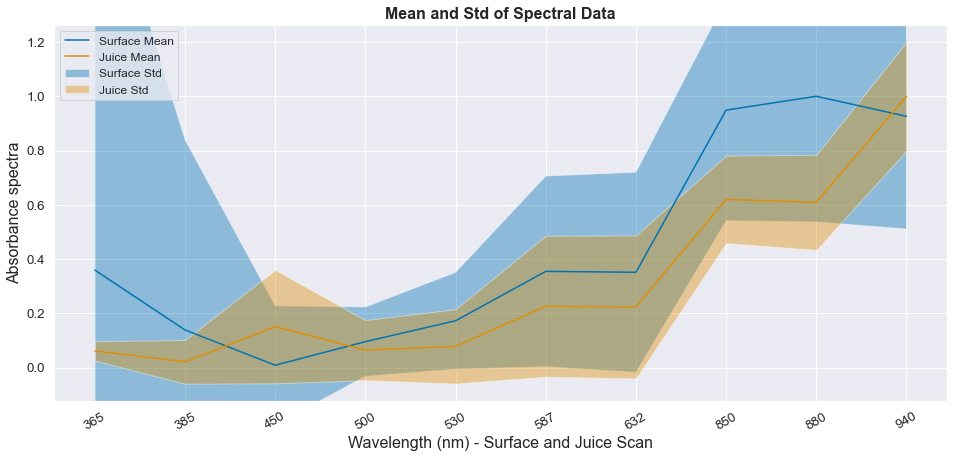

In [5]:
compare_plot_mean_std(df1 = df_surface, df2 = df_juice,
                      xlabel="Wavelength (nm) - Surface and Juice Scan", ylabel="Absorbance spectra", title="Mean and Std of Spectral Data",
                      label_mean="Surface Mean", label_std="Surface Std", label_mean2="Juice Mean", label_std2="Juice Std", figsize=(16,6))

## Preprocessing
The objective of preprocessing is to remove physical phenomena in the spectra in order to improve the subsequent multivariate in regression, classification model or exploratory analysis. The preprocessing techniues can be devided into 2 categories: scatter correction and spectral derivatives.

Preprocessing of spectral data is the most important step before chemometric bi-linear modeling.For solid samples, undesired systematic variations are primarily caused by ligth scattering and differences in the effective path length. Thses undesired variations often constitute the major part of the total variation in the sample set, and can be observed as shifts in baseline (multiplicative effects) and other phenomena called non-linearities. In general, NIR measurement of a sample will measure diffusely reflected and specular reflected radiation.

- __Columns: Surface Scans__
- __Type: Kale__

In [6]:
kale_surface_index = df[df["Type"]=="kale"][surface_col].dropna().index
x = df[df["Type"]=="kale"][surface_col].dropna().values

### MSC - Multivariate Scatter Correction
MSC is a standardization technique. It aims to correct the spectra so that they are as close as possible to a reference spectrum, generally the average, by modifying the scale and the offset of the spectra. The MSC links all spectra to a common reference. This is an efficient method to minimize base shifts and the multiplicative effect. Light scattering effects according to sample size and path wavelength should vary randomly from sample to sample, and therefore the average should reasonably reduce these effects, at least in approximations that these effects are really random.

Mathematically, if **Xm** is the average spectrum, the MSC is done in 2 steps:
1. Each spectrum Xi is regressed against the reference spectrum. This is done by the ordinary least squares method: __Xi≈ ai+bi.Xm__
2. We calculate the corrected spectrum
$$X_i^{MSC} = \frac{(X_i-a_i)}{b_i}$$

In [7]:
def msc(input_data, reference=None):
    """Perform Multiplicative scatter correction
    Parameters
    ----------
    input_data : <numpy.darray>
        NIRS data matrix

    Return
    ------
    Return 
    """

    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i, :] -= input_data[i, :].mean()

    # Get the reference spectrum. If not given, estimate it from the mean
    if reference is None:
        # calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference

    # Define a new array and populate it with the corrected data
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i, :], 1, full=True)
        # Apply correction
        data_msc[i, :] = (input_data[i, :] - fit[0][1]) / fit[0][0]

    return data_msc

In [8]:
# Apply preprocessing on raw data
x_msc = msc(x)
msc_df = pd.DataFrame(x_msc, index=kale_surface_index, columns=wavelength)

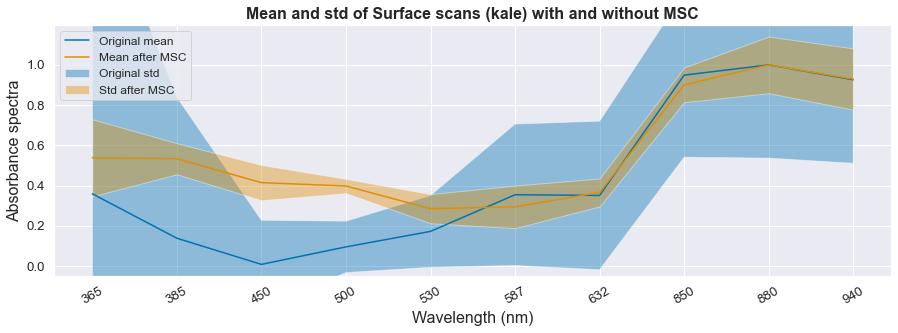

In [9]:
compare_plot_mean_std(df1=df_surface, df2=msc_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of Surface scans (kale) with and without MSC",
                     label_mean="Original mean", label_std="Original std", label_mean2="Mean after MSC", label_std2="Std after MSC")

The advantage of the MSC is to be able to link all the spectra to a common reference. If the reference spectrum has a good approximation and if this reference is close to a spectrum free from unwanted scattering.

### SNV - Standard Normal Variate
SNV is a method of preprocessing in scatter correction. SNV is often used on spectra where changes in baseline and path length cause differences between otherwise identical spectra. (SNV is similar to normalization). Like MSC, the goal is to get rid of all effects that are not related to the chemical nature of the sample. The scattering of light due to the interactions between the NIR radiation and the Particles in the sample often create a shift in absorbance levels which makes spectral interpretation more difficult.

SNV transformation was introduced to reduce the multiplicative effects of scattering and sample size, and also to reduce differences in the global intensities of the signals. Each spectrum is centered and then scaled by dividing by its standard deviation. Unlike the MSC, the SNV method is performed on each individual spectrum, and a reference spectrum is not a reference.
1. Take the average of each spectrum
2. Divide each mean by its own standard deviation:
$$X_i^{SNV} = \frac{(X_i-\bar{X})}{\sigma_i}$$
$$X_i: spectrum$$
$$\bar{X}_i: spectrum~mean$$
$$\sigma_i: spectrum~standard~deviation $$

In [10]:
def snv(input_data):
    """Apply Standard Normal Variate

    Parameters
    ----------
    input_data : <numpy.darray>
        NIRS data matrix

    Return
    ------
    Return 
    """

    # Define a new array and populate it with the corrected data
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        output_data[i, :] = (
            input_data[i, :] - np.mean(input_data[i, :])) / np.std(input_data[i, :])

    return output_data

In [11]:
# Apply preprocessing on raw data
x_snv = snv(x)
snv_df = pd.DataFrame(x_snv, index=kale_surface_index, columns=wavelength)

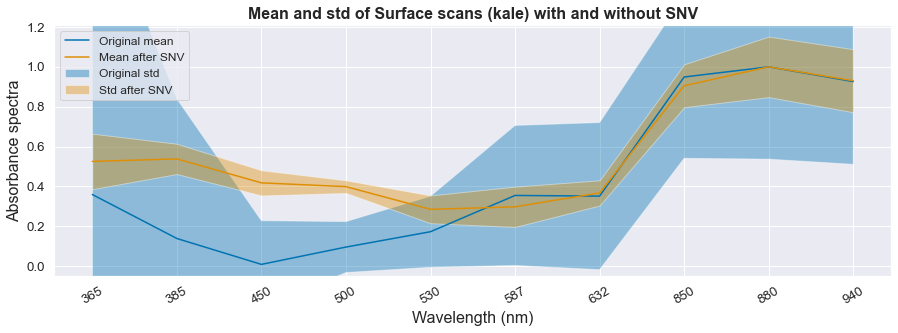

In [12]:
compare_plot_mean_std(df1=df_surface, df2=snv_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of Surface scans (kale) with and without SNV",
                     label_mean="Original mean", label_std="Original std", label_mean2="Mean after SNV", label_std2="Std after SNV")

If outliers are present in the dataset, the reference spectrum may not be a good reference and the MSC is not the right choice. Instead, use SNV.

### Savitzky-Golay
Explication soon soon...

In [13]:
def savgol_smoothing(x, window_length=5, polyorder=2, deriv_order=0, delta=1.0):
    return savgol_filter(x, window_length, polyorder)

In [14]:
# Apply preprocessing on raw data
x_savgol = savgol_smoothing(x)
savgol_df = pd.DataFrame(x_savgol, index=kale_surface_index, columns=wavelength)

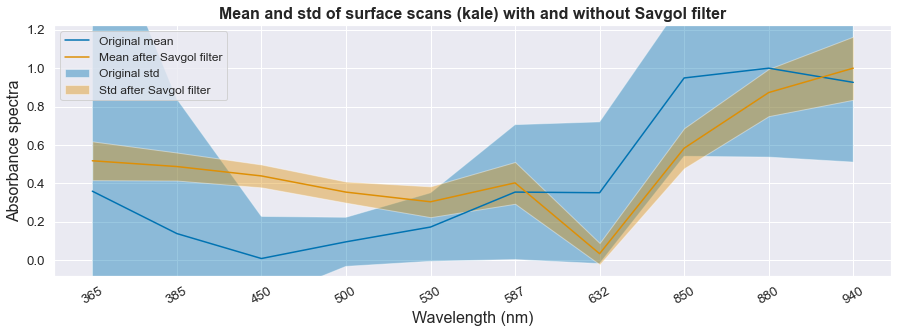

In [15]:
compare_plot_mean_std(df1=df_surface, df2=savgol_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of surface scans (kale) with and without Savgol filter",
                     label_mean="Original mean", label_std="Original std", label_mean2="Mean after Savgol filter", label_std2="Std after Savgol filter")

### Detrend
Explication soon soon...

In [16]:
def detrend(spectra, bp=0):
    """ Perform spectral detrending to remove linear trend from data.
    Parameters
    ----------
    spectra : <numpy.ndarray>
        NIRS data matrix
    bp : <list>
        A sequence of break points. If given, an individual linear fit is performed for each part of data
        between two break points. Break points are specified as indices into data.
    Return
    ------
    Return spectra <numpy.ndarray>: Detrended NIR spectra
    """
    return scipy.signal.detrend(spectra, bp=bp)

In [17]:
# Apply preprocessing on raw data
x_detrend = detrend(x)
detrend_df = pd.DataFrame(x_detrend, index=kale_surface_index, columns=wavelength)

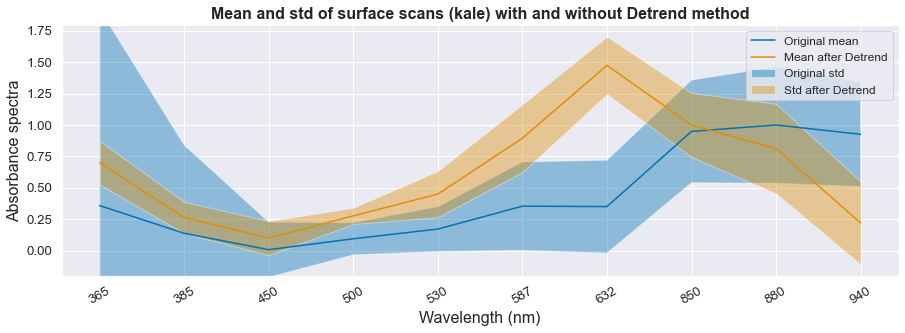

In [18]:
compare_plot_mean_std(df1=df_surface, df2=detrend_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of surface scans (kale) with and without Detrend method",
                     label_mean="Original mean", label_std="Original std", label_mean2="Mean after Detrend", label_std2="Std after Detrend")

### Spectral normalization
Explication soon soon...

In [19]:
def norml(spectra, udefined=True, imin=0, imax=1):
    """ Perform spectral normalisation with user-defined limits.
    Parameters
    ----------
        spectra <numpy.ndarray>: NIRS data matrix.
        udefined <bool>: use user defined limits
        imin <float>: user defined minimum
        imax <float>: user defined maximum

    Returns
    -------
        spectra <numpy.ndarray>: Normalized NIR spectra
    """
    if udefined:
        f = (imax - imin)/(np.max(spectra) - np.min(spectra))
        n = spectra.shape
        # create empty array for spectra
        arr = np.empty((0, n[0]), dtype=float)
        for i in range(0, n[1]):
            d = spectra[:, i]
            dnorm = imin + f*d
            arr = np.append(arr, [dnorm], axis=0)
        return np.transpose(arr)
    else:
        return spectra / np.linalg.norm(spectra, axis=0)

In [20]:
# Apply preprocessing on raw data
x_norml = norml(x)
norml_df = pd.DataFrame(x_norml, index=kale_surface_index, columns=wavelength)

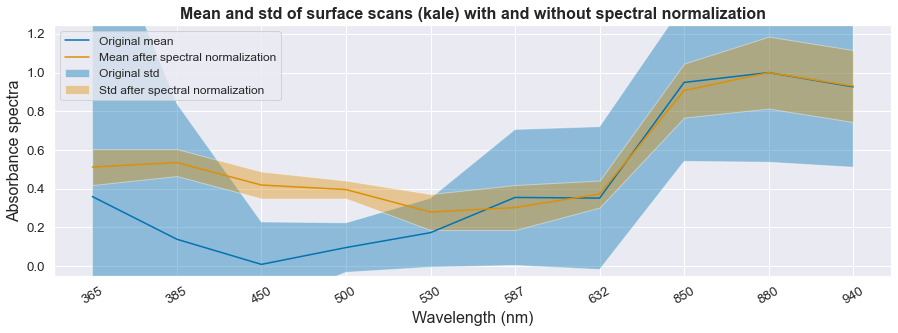

In [21]:
compare_plot_mean_std(df1=df_surface, df2=norml_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of surface scans (kale) with and without spectral normalization",
                     label_mean="Original mean", label_std="Original std", label_mean2="Mean after spectral normalization", label_std2="Std after spectral normalization")